# Вебинар 5. Ранжирование и Гибридные рекоммендательные системы

# 1. Ранжирование

### 1.1 BPR - Bayesian Personalized Ranking loss

$$loss = \sigma(p^{+} - p^{-})$$

1. Случайная пара user - купленный им item_i = позитивная пара
2. Для того же юзера сэмплируем item_j (не купил или вес в user-item матрице ниже, у item_i из 1.) - негативная пара
3. Прогнозы модели $p^{+}$, $p^{-}$ --> $p^{+} - p^{-}$
4. loss = $\sigma(p^{+} - p^{-})$ - это и есть наша ошибка
5. Обновляем эмбеддинги

### 1.2 WARP = Weighted Approximate-Rank Pairwise loss
Неплохое [объяснение](https://medium.com/@gabrieltseng/intro-to-warp-loss-automatic-differentiation-and-pytorch-b6aa5083187a) на игрушечном примере

$$loss = ln(\frac{K-1}{N})*(p^- - p^+)$$

1. Сэмплируем случайную позитивную пару юзер-item, прогноз модели для этой пары $p^+$
2. Сюмплируем далее до тех пор, пока не найдем негативную пару, гду прогнозная вероятность вероятность $p^-$ > $p^+$
3. K - кол-во сэмплирований (зависит от качества модели!)
4. N - общее количество рекомендаций

**Note**  
loss зависит только от 2-ух сэмплированных пар, эмбеддинги только для этих пар будут обновлены

In [ ]:
# Case 1
p_plus = 4.3  # true = 1
p_neg_1 = -2.3 
p_neg_2 = 4.5

loss(random_seed) = ln[(10-1) / 3] * (4.5 - 4.3)

# Case 2 -  модель лучше в этом случае
p_plus = 4.3  # true = 1
p_neg_1 = -2.3 
p_neg_2 = 0.5
p_neg_3 = -0.5
p_neg_4 = 2.1
p_neg_5 = 4.5

loss(random_seed) = ln[(10-1) / 6] * (4.5 - 4.3)

### Зачем нужно ранжирование? Есть же классификация (предсказание 0 и 1)
- Ранжирование гораздо лучше выбирает топ-k товаров, особенно когда k велико
- Ранжирование позволяет напрямую ранжировать 5 релевантных юзеру товаров (какой из 5 поставить выше?)

---

# 2. LightFM

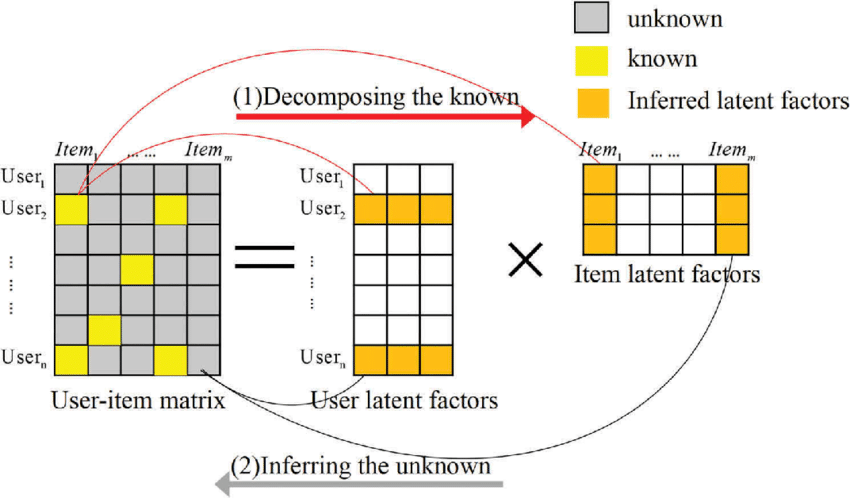

Формула эмбеддинга в ALS (матричной факторизации)

$$user_{emb} = \theta_1 * i_1 + ... + \theta_n * i_n$$  
  
$$p = user_{emb} * item_{emb}^T + b_u + b_i$$

Формула в LightFM

$$user_{emb} = \theta_1 * i_1 + ... + \theta_n * i_n + \alpha_1 * f_1 + ... + \alpha_k * f_k$$  
  
$$p = user_{emb} * item_{emb}^T + b_u + b_i$$

### Зачем нужны гибридные системы?

*Холодный старт* - ситуация, в которой с товаром/юзером в матрице мало взаимодействий

Холодный страт для товаров - обычно введение нового товара (YouTube, Lamoda, hh.ru)  
Холодный старт для юзера - к нам пришел новый юзер  

Холодного юзера/товар можно описать фичами --> мы больше о нем знаем --> он уже не такой холодный

In [3]:
!pip install matplotlib seaborn pandas lightgbm xgboost catboost

     |████████████████████████████████| 11.3 MB 5.0 MB/s            
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
     |████████████████████████████████| 11.7 MB 432 kB/s            
     |████████████████████████████████| 2.0 MB 1.3 MB/s            
     |████████████████████████████████| 173.6 MB 1.1 MB/s            
     |████████████████████████████████| 76.1 MB 4.7 MB/s            
     |████████████████████████████████| 1.2 MB 4.0 MB/s            
     |████████████████████████████████| 895 kB 4.1 MB/s            
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     |████████████████████████████████| 4.3 MB 2.2 MB/s            
  Using cached pytz-2021.3-py2.py3-none-any.whl (503 kB)
     |████████████████████████████████| 46 kB 1.0 MB/s            
     |████████████████████████████████| 26.5 MB 4.4 MB/s            


In [2]:
!pip install lightfm

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# from src.metrics import precision_at_k, recall_at_k
from utils import prefilter_items

In [5]:
data = pd.read_csv('retail_train.csv')

item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [7]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [8]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [9]:
user_features['marital_status_code'].unique()

array(['A', 'U', 'B'], dtype=object)

In [10]:
user_features['household_size_desc'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

## 1. Filter items

In [11]:
data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [12]:
n_items_train_before = data_train['item_id'].nunique()
n_items_test_before = data_test['item_id'].nunique()
n_users_train_before = data_train['user_id'].nunique()
n_users_test_before = data_test['user_id'].nunique()

data_train_filtered = prefilter_items(data_train, take_n_popular=5000, item_features=item_features)
data_test_filtered = prefilter_items(data_test, take_n_popular=5000, item_features=item_features)

n_items_train_after = data_train_filtered['item_id'].nunique()
n_items_test_after = data_test_filtered['item_id'].nunique()
n_users_train_after = data_train_filtered['user_id'].nunique()
n_users_test_after = data_test_filtered['user_id'].nunique()
print('Decreased # items_train from {} to {}'.format(n_items_train_before, n_items_train_after))
print('Decreased # items_test from {} to {}'.format(n_items_test_before, n_items_test_after))
print('Decreased # users_train from {} to {}'.format(n_users_train_before, n_users_train_after))
print('Decreased # users_test from {} to {}'.format(n_users_test_before, n_users_test_after))

Decreased # items_train from 86865 to 5001
Decreased # items_test from 24329 to 5001
Decreased # users_train from 2499 to 2497
Decreased # users_test from 2042 to 1990


# 2. Prepare data set

## 2.1 Prepare csr train matrix

In [58]:
def get_sparse_user_item(data_train_filtered):
    user_item_matrix = pd.pivot_table(data_train_filtered, 
                                      index='user_id', columns='item_id', 
                                      values='quantity', # Можно пробоват ьдругие варианты
                                      aggfunc='count', 
                                      fill_value=0
                                     )

    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

    # переведем в формат saprse matrix
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()
    return user_item_matrix, sparse_user_item


## 2.2 Prepare CSR test matrix

In [87]:
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]
def get_test_user_item_matrix(data_test):
    test_user_item_matrix = pd.pivot_table(data_test_filtered, 
                                      index='user_id', columns='item_id', 
                                      values='quantity', # Можно пробовать другие варианты
                                      aggfunc='count', 
                                      fill_value=0
                                     )

    test_user_item_matrix = test_user_item_matrix.astype(float) # необходимый тип матрицы для implicit
    return test_user_item_matrix

In [15]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

## 3. Prepare user and item features

In [60]:
def get_user_feat(user_item_matrix):
    user_feat = pd.DataFrame(user_item_matrix.index)
    user_feat = user_feat.merge(user_features, on='user_id', how='left')
    user_feat.set_index('user_id', inplace=True)
    return user_feat


In [17]:
user_feat.shape

(2497, 7)

In [89]:
def get_item_feat(user_item_matrix):
    item_feat = pd.DataFrame(user_item_matrix.columns)
    item_feat = item_feat.merge(item_features, on='item_id', how='left')
    item_feat.set_index('item_id', inplace=True)
    return item_feat

In [19]:
item_feat.shape

(5001, 6)

## Encoding features

In [20]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [21]:
user_feat_lightfm.head(2)

,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,income_desc_100-124K,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
item_feat_lightfm.head(2)

,manufacturer_2.0,manufacturer_5.0,manufacturer_16.0,manufacturer_20.0,manufacturer_26.0,manufacturer_33.0,manufacturer_35.0,manufacturer_36.0,manufacturer_42.0,manufacturer_43.0,...,curr_size_of_product_L 16 OZ,curr_size_of_product_L 7.75 OZ,curr_size_of_product_L 13.25 OZ,curr_size_of_product_LB,curr_size_of_product_N 12 OZ,curr_size_of_product_N 40 OZ,curr_size_of_product_PINT,curr_size_of_product_PK,curr_size_of_product_PT,curr_size_of_product_QT
item_id,,,,,,,,,,,,,,,,,,,,,
117847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
818981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Init model

In [23]:
model = LightFM(no_components=40,
                 loss='bpr',
                #loss='warp',
                learning_rate=0.05, 
                item_alpha=0.1,
                user_alpha=0.1, 
                random_state=42)

## Train

In [24]:
%%time

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4,
          verbose=False) 

CPU times: user 1min 59s, sys: 0 ns, total: 1min 59s
Wall time: 32.3 s


# Evaluation

In [25]:
user_emb = model.get_user_representations(features=csr_matrix(user_feat_lightfm.values).tocsr())

In [26]:
user_emb[0]  # biases

array([-69.82808,   0.     ,   0.     , ..., -72.73215, -45.87857,
         0.     ], dtype=float32)

In [27]:
user_emb[0].shape

(2497,)

In [28]:
user_emb[1]  # embeddings

array([[ 8.7258092e-04,  6.3518167e-04, -1.6732735e-04, ...,
         1.4527907e-04,  4.6712541e-04,  5.5146939e-04],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 2.9384688e-04, -9.3830822e-06,  3.4379445e-05, ...,
         3.5411780e-04,  6.2034052e-04,  1.4813255e-04],
       [ 1.6090472e-03,  1.5475250e-04,  8.7267067e-04, ...,
         5.8152177e-04, -1.5279988e-03,  5.1167799e-04],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [29]:
user_emb[1].shape

(2497, 40)

In [30]:
item_emb = model.get_item_representations(features=csr_matrix(item_feat_lightfm.values).tocsr())

In [31]:
item_emb[0].shape

(5001,)

In [32]:
item_emb[1].shape

(5001, 40)

# Train precision

In [33]:
train_precision = precision_at_k(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

train_precision

0.21169405

In [34]:
0.21097319 bpr

SyntaxError: invalid syntax (2791416386.py, line 1)

In [ ]:
0.29411295 warp

In [35]:
test_item_ids = np.array([1, 2, 3, 200, 1200])

predictions = model.predict(user_ids=0,
                            item_ids=test_item_ids,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=4)

In [36]:
predictions

array([-108.91152 , -108.82706 , -108.303856, -108.03863 , -108.72677 ],
      dtype=float32)

In [37]:
predictions

array([-108.91152 , -108.82706 , -108.303856, -108.03863 , -108.72677 ],
      dtype=float32)

# Test precision

In [38]:
test_precision = precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(), 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

test_precision

0.0023115578

In [ ]:
0.0024120605  bpr

In [ ]:
0.0028140703 warp

Neural networks for RS: http://d2l.ai/chapter_recommender-systems/mf.html

LigthFM -> https://arxiv.org/pdf/1507.08439.pdf

https://making.lyst.com/lightfm/docs/home.html


predictions - некоторые числа. 

# Домашнее задание

1) Прочитать статьи про BPR, WARP loss

2) Сделать грид серч текущей модели

# Подбор параметров на сетке

https://hyperopt.github.io/hyperopt/ 

In [118]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, scope

In [117]:
from functools import partial

In [84]:
model = LightFM(random_state=12)

In [115]:
search_space = {'no_components': scope.int(hp.quniform(label='n_component',
                                           low=30, high=500, q=10)),
               'loss': hp.choice(label='loss', options=['bpr', 'warp']),
                'learning_rate': hp.uniform(label='learning_rate',
                                               low=1e-4, high=0.1),
                'item_alpha': hp.uniform(label='item_alpha',
                                            low=1e-2, high=0.3),
                'user_alpha': hp.uniform(label='user_alpha',
                                            low=1e-2, high=0.3)
               }

In [116]:
def objective(params, model, data_train_filtered, data_test):
    
    model.set_params(**params)
    
    user_item_matrix, sparse_user_item = get_sparse_user_item(data_train_filtered)
    
    test_user_item_matrix = get_test_user_item_matrix(data_test)
    
    user_feat = get_user_feat(user_item_matrix)
    item_feat = get_item_feat(user_item_matrix)
    
    user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
    item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())
    
    model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=20, 
          num_threads=8,
          verbose=False) 
    
    score = precision_at_k(model, csr_matrix(test_user_item_matrix).tocsr(), 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()
    return   {'loss': -score, 'params': params, 'status': STATUS_OK}

In [119]:
trials = Trials()
best = fmin(fn=partial(objective, model=model, 
                       data_train_filtered=data_train_filtered,
                      data_test=data_test),
            space=search_space,
            algo=tpe.suggest, 
            max_evals=100,
            trials=trials,
            show_progressbar=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:51:40<00:00, 103.01s/trial, best loss: -0.013768845237791538]


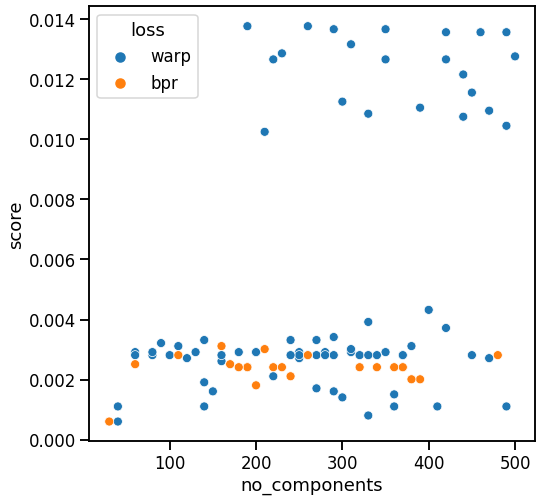

In [143]:
import seaborn as sns

def df_results(hp_results):
    """
    Отображаем результаты hyperopt в формате DataFrame 

    :hp_results: результаты hyperop
    :return: pandas DataFrame
    """ 

    results = pd.DataFrame([{**x} for x in  trials.results])
    results.rename(columns={'loss': 'score'}, inplace=True)
    results = results.join(pd.DataFrame([{**x['params']} for x in  trials.results]))
    results['score'] = results['score'].apply(lambda x: -x)
    results
    results.drop(labels=['status', 'params'], axis=1, inplace=True)
    results.sort_values(by=['loss'], ascending=False, inplace=True)
    return results

results = df_results(trials.results)
sns.set_context("talk")
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='no_components', y='score', hue='loss', 
                                                   data=results);
# ax.set_xscale('log')
# ax.set_xlim(1e-4, 2e2)
# ax.grid()

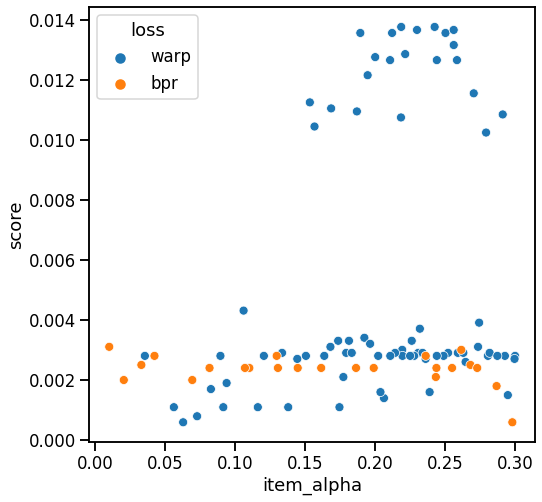

In [144]:
sns.set_context("talk")
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='item_alpha', y='score', hue='loss', 
                                                   data=results);

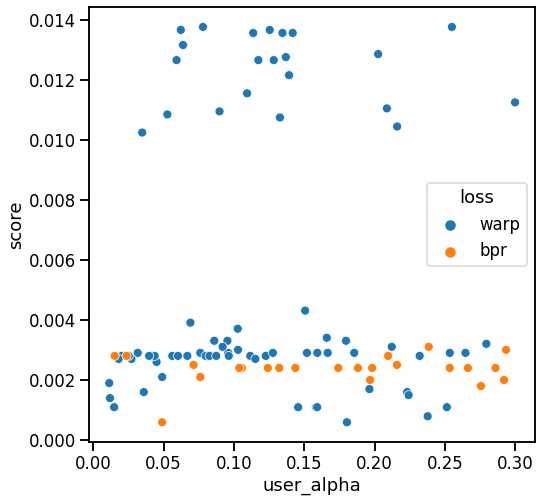

In [145]:
sns.set_context("talk")
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='user_alpha', y='score', hue='loss', 
                                                   data=results);

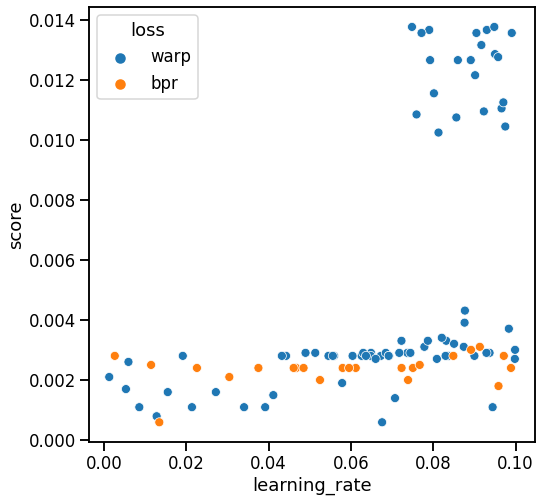

In [146]:
sns.set_context("talk")
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='learning_rate', y='score', hue='loss', 
                                                   data=results);

In [147]:
best

{'item_alpha': 0.24249019859146986,
 'learning_rate': 0.09484723546779775,
 'loss': 1,
 'n_component': 260.0,
 'user_alpha': 0.07793703683283475}

# Статья о использование рекомендательных систем в инвестициях

https://arxiv.org/pdf/2104.12484.pdf